# Single Fit

In [140]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import numpy as np
import pandas as pd 
from BHDVCS_torch import TBHDVCS

import BHDVCS_fit as dvcsfit

import matplotlib
import matplotlib.pyplot as plt

from scipy.stats import chisquare

import wandb

### Load functions and choose set to fit
change setnum to choose which set to fit

In [362]:
tb = TBHDVCS()

f = tb.TotalUUXS_curve_fit3

loss_func = tb.loss_MSE

setnum = 6
a = setnum*36
b = a + 36

### Load in data

In [363]:
dats = pd.read_csv('dvcs_psuedo.csv')

n = np.array(dats['#Set'])[a:b]
ind = np.array(dats['index'])[a:b]
k = np.array(dats['k'])[a:b]
qq = np.array(dats['QQ'])[a:b]
xb = np.array(dats['x_b'])[a:b]
t = np.array(dats['t'])[a:b]
phi = np.array(dats['phi_x'])[a:b]
ydat = np.array(dats['F'])[a:b]  
errF = np.array(dats['errF'])[a:b]  
F1 = np.array(dats['F1'])[a:b]  
F2 = np.array(dats['F2'])[a:b]  
const = np.array(dats['dvcs'])[a:b]  
ReH_target = np.array(dats['ReH'])[a:b]  
ReE_target = np.array(dats['ReE'])[a:b]  
ReHT_target = np.array(dats['ReHtilde'])[a:b]

### Set pytorch variables
***Note: BHDVCS.py file must be changed so that all functions are pytorch***

In [364]:
xdat = np.asarray([phi, qq, xb, t, k, F1, F2, const])
x = Variable(torch.from_numpy(xdat[1:5].transpose()))
y = Variable(torch.from_numpy(ydat.transpose()))
xdat = Variable(torch.from_numpy(xdat))
errs = Variable(torch.from_numpy(errF))

## Network Architecture:
Inputs: 36 instances of 8 variables (phi, qq, xb, t, kk, F1, F2, const) \
Outputs: 3 compton form factors \
Loss: Mean of squares between F(net outputs) vs F(given)

In [373]:
nodes = 100
net = torch.nn.Sequential(
        torch.nn.Linear(4, nodes),
        torch.nn.Tanh(),
        torch.nn.Linear(nodes, nodes),
        torch.nn.Tanh(),
        torch.nn.Linear(nodes, nodes),
        torch.nn.Tanh(),
        torch.nn.Linear(nodes, nodes),
        torch.nn.Tanh(),
        torch.nn.Linear(nodes, nodes),
        torch.nn.Tanh(),
        torch.nn.Linear(nodes, nodes),
        torch.nn.Tanh(),
#         torch.nn.Linear(nodes, nodes),
#         torch.nn.Tanh(),
#         torch.nn.Linear(nodes, nodes),
#         torch.nn.Tanh(),
#         torch.nn.Linear(nodes, nodes),
#         torch.nn.Tanh(),
        torch.nn.Linear(nodes, 3)
    )

### Set optimizer and choose number of epochs

In [374]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.1)
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.99)
EPOCH = 2500

losses = []
losses.clear()

### Train Network

In [375]:

for epoch in range(EPOCH):

    
    p = net(x.float()) #output 3 predicted values for cffs

    ReHfit = torch.mean(torch.transpose(p, 0, 1)[0])
    ReEfit = torch.mean(torch.transpose(p, 0, 1)[1])
    ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2])
    cffs = [ReHfit, ReEfit, ReHTfit]

    loss = loss_func((xdat.float()), cffs, errs, y)
    losses.append(float(loss.data.float()))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
print("Training Complete")

Training Complete


### Show final fit statistics

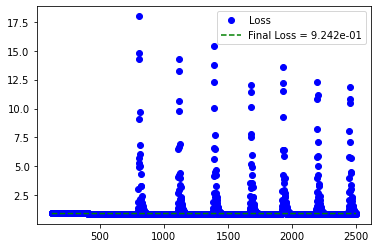



      Fit Value of ReH = 10.14
   Actual Value of ReH = 11.74
           Error (ReH) = 13.6%

      Fit Value of ReE = -42.17
   Actual Value of ReE = -51.74
           Error (ReE) = 18.5%

     Fit Value of ReHT = 6.84
  Actual Value of ReHT = 6.52
          Error (ReHT) = 4.8%

Chi-Squared Value for this fit: 4.727e-03
Chi-Squared Value for expected fit: 4.402e-03
MSE Loss Value for this fit: 9.242e-01
Average Error for set #6 using ANN = 12.31%
Average Error for set #6 using scipy = 7.93%


(9.33944620497895, 12.133705963178837, 2.3037103994103676)

In [376]:
plt.plot(np.linspace(int(.05*EPOCH), EPOCH, int(.95*EPOCH)), np.asarray(losses)[int(.05*EPOCH):], 'bo', label='Loss')
plt.plot(np.linspace(int(.05*EPOCH), EPOCH, int(.95*EPOCH)), np.zeros(int(0.95*EPOCH))+float(loss.data.float()), 'g--',             label='Final Loss = %.3e' % (float(loss.data.float())))
plt.legend()
plt.show()
ReHfit = torch.mean(torch.transpose(p, 0, 1)[0]).data.numpy()
ReEfit = torch.mean(torch.transpose(p, 0, 1)[1]).data.numpy()
ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2]).data.numpy()
fit_cffs = [ReHfit, ReEfit, ReHTfit]

err_H = abs(100*(abs(fit_cffs[0]-ReH_target[0]))/ReH_target[0])
err_E = abs(100*(abs(fit_cffs[1]-ReE_target[0]))/ReE_target[0])
err_HT = abs(100*(abs(fit_cffs[2]-ReHT_target[0]))/ReHT_target[0])
    
print('\n\n%25s%.2f' % ('Fit Value of ReH = ', cffs[0]))
print('%25s%.2f' % ('Actual Value of ReH = ', ReH_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReH) = ', err_H))

print('%25s%.2f' % ('Fit Value of ReE = ', cffs[1]))
print('%25s%.2f' % ('Actual Value of ReE = ', ReE_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReE) = ', err_E))

print('%25s%.2f' % ('Fit Value of ReHT = ', cffs[2]))
print('%25s%.2f' % ('Actual Value of ReHT = ', ReHT_target[0]))
print('%25s\033[1m%.1f%%\033[0m\n' % ('Error (ReHT) = ', err_HT))

print('Chi-Squared Value for this fit: %.3e' % (chisquare(f(xdat,fit_cffs), ydat)[0]))
print('Chi-Squared Value for expected fit: %.3e' % (chisquare(f(xdat,[ReH_target[0], ReE_target[0], ReHT_target[0]]), ydat)[0]))
print('MSE Loss Value for this fit: %.3e' % (float(loss.data.float())))
print('Average Error for set #%d using ANN = %.2f%%' % ((setnum), ((err_H+err_E+err_HT)/3)))
dvcsfit.fit_scipy(setnum)


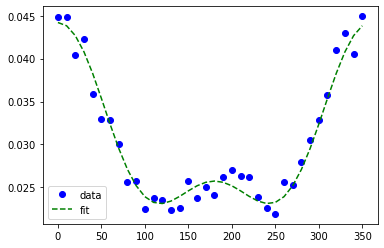

In [359]:
plt.plot(phi, ydat, 'bo', label='data')
plt.plot(phi, f(xdat,fit_cffs), 'g--', label='fit')
plt.legend()
plt.show()

# Finding Error of Fit for each Set:

In [3]:
dats = pd.read_csv('dvcs_psuedo.csv')
n = np.array(dats['#Set'])
ind = np.array(dats['index'])
k = np.array(dats['k'])
qq = np.array(dats['QQ'])
xb = np.array(dats['x_b'])
t = np.array(dats['t'])
phi = np.array(dats['phi_x'])
ydat = np.array(dats['F'])
errF = np.array(dats['errF']) 
F1 = np.array(dats['F1'])
F2 = np.array(dats['F2'])
const = np.array(dats['dvcs'])  
ReH_target = np.array(dats['ReH']) 
ReE_target = np.array(dats['ReE']) 
ReHT_target = np.array(dats['ReHtilde'])
err_H = []
err_E = []
err_HT = []

EPOCH = 2700

# bads = [1, 4, 6, 8, 9, 11]

## Repeat steps above over each set in data
Print graph of loss decrease and fit, chi squared value of fit, and average error in form factors for both the neural net fit and our baseline scipy fit.

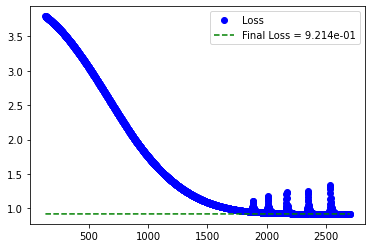

ReHfit: 13.72, Actual: 13.06, Error: 5.12%
ReEfit: -56.59, Actual: -53.06, Error: 6.65%
ReHTfit: 6.81, Actual: 7.25, Error: 6.10%
Chi-Squared Value for this fit: 4.311e-03
Chi-Squared Value for expected fit: 4.397e-03
MSE Loss Value for this fit: 9.214e-01
Average Error for set #0 using ANN = 5.96%
Average Error for set #0 using scipy = 8.25%
-


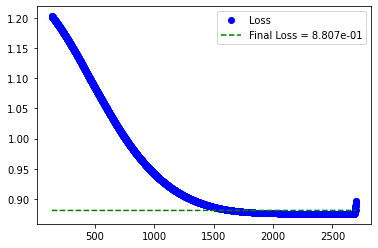

ReHfit: 11.71, Actual: 12.55, Error: 6.74%
ReEfit: -47.51, Actual: -52.55, Error: 9.60%
ReHTfit: 7.50, Actual: 6.97, Error: 7.47%
Chi-Squared Value for this fit: 7.067e-03
Chi-Squared Value for expected fit: 7.247e-03
MSE Loss Value for this fit: 8.807e-01
Average Error for set #1 using ANN = 7.93%
Average Error for set #1 using scipy = 1.18%
-


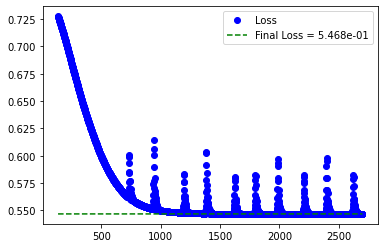

ReHfit: 6.54, Actual: 7.22, Error: 9.53%
ReEfit: -43.16, Actual: -47.22, Error: 8.60%
ReHTfit: 4.49, Actual: 4.01, Error: 11.79%
Chi-Squared Value for this fit: 2.889e-03
Chi-Squared Value for expected fit: 2.951e-03
MSE Loss Value for this fit: 5.468e-01
Average Error for set #2 using ANN = 9.97%
Average Error for set #2 using scipy = 12.91%
-


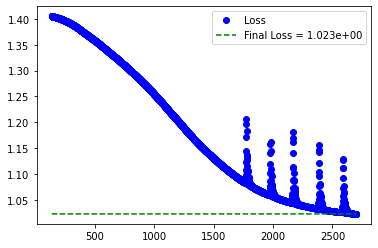

ReHfit: 7.22, Actual: 7.65, Error: 5.62%
ReEfit: -45.62, Actual: -47.65, Error: 4.28%
ReHTfit: 4.09, Actual: 4.25, Error: 3.75%
Chi-Squared Value for this fit: 4.062e-03
Chi-Squared Value for expected fit: 4.052e-03
MSE Loss Value for this fit: 1.023e+00
Average Error for set #3 using ANN = 4.55%
Average Error for set #3 using scipy = 9.20%
-


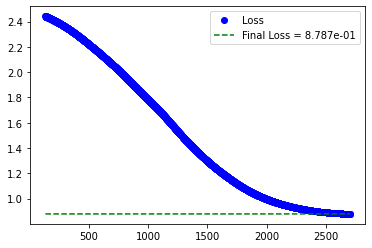

ReHfit: 11.01, Actual: 12.55, Error: 12.33%
ReEfit: -44.42, Actual: -52.55, Error: 15.48%
ReHTfit: 7.37, Actual: 6.97, Error: 5.61%
Chi-Squared Value for this fit: 2.689e-03
Chi-Squared Value for expected fit: 2.768e-03
MSE Loss Value for this fit: 8.787e-01
Average Error for set #4 using ANN = 11.14%
Average Error for set #4 using scipy = 4.84%
-


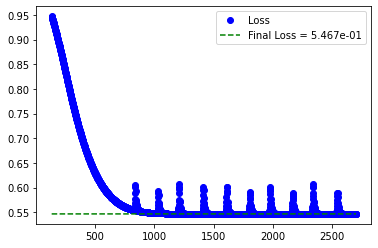

ReHfit: 6.72, Actual: 7.22, Error: 7.01%
ReEfit: -44.27, Actual: -47.22, Error: 6.25%
ReHTfit: 4.27, Actual: 4.01, Error: 6.31%
Chi-Squared Value for this fit: 1.653e-03
Chi-Squared Value for expected fit: 1.689e-03
MSE Loss Value for this fit: 5.467e-01
Average Error for set #5 using ANN = 6.53%
Average Error for set #5 using scipy = 8.27%
-


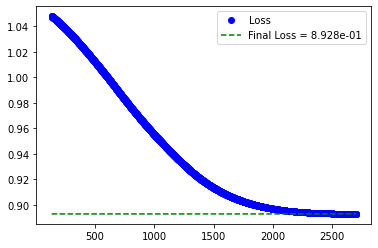

ReHfit: 9.91, Actual: 11.74, Error: 15.61%
ReEfit: -41.36, Actual: -51.74, Error: 20.07%
ReHTfit: 7.06, Actual: 6.52, Error: 8.25%
Chi-Squared Value for this fit: 4.353e-03
Chi-Squared Value for expected fit: 4.402e-03
MSE Loss Value for this fit: 8.928e-01
Average Error for set #6 using ANN = 14.64%
Average Error for set #6 using scipy = 7.93%
-


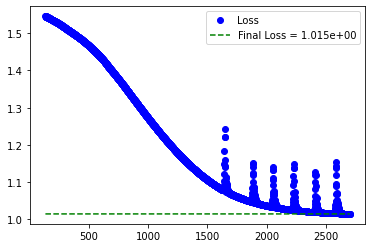

ReHfit: 7.96, Actual: 7.65, Error: 4.02%
ReEfit: -49.32, Actual: -47.65, Error: 3.50%
ReHTfit: 4.34, Actual: 4.25, Error: 2.18%
Chi-Squared Value for this fit: 2.630e-03
Chi-Squared Value for expected fit: 2.674e-03
MSE Loss Value for this fit: 1.015e+00
Average Error for set #7 using ANN = 3.23%
Average Error for set #7 using scipy = 10.68%
-


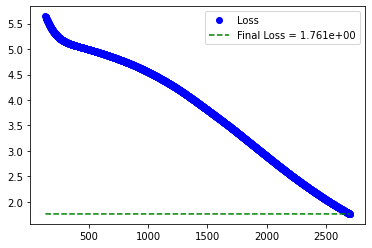

ReHfit: 7.41, Actual: 12.55, Error: 40.96%
ReEfit: -25.92, Actual: -52.55, Error: 50.67%
ReHTfit: 6.18, Actual: 6.97, Error: 11.43%
Chi-Squared Value for this fit: 3.311e-03
Chi-Squared Value for expected fit: 1.718e-03
MSE Loss Value for this fit: 1.761e+00
Average Error for set #8 using ANN = 34.36%
Average Error for set #8 using scipy = 5.51%
-


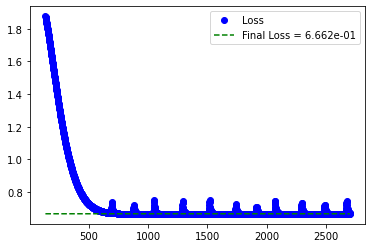

ReHfit: 8.11, Actual: 6.99, Error: 15.97%
ReEfit: -53.58, Actual: -46.99, Error: 14.02%
ReHTfit: 3.16, Actual: 3.88, Error: 18.51%
Chi-Squared Value for this fit: 2.396e-03
Chi-Squared Value for expected fit: 2.861e-03
MSE Loss Value for this fit: 6.662e-01
Average Error for set #9 using ANN = 16.17%
Average Error for set #9 using scipy = 15.53%
-


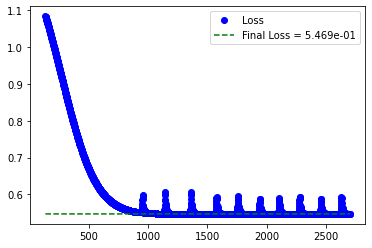

ReHfit: 6.79, Actual: 7.22, Error: 6.04%
ReEfit: -44.67, Actual: -47.22, Error: 5.42%
ReHTfit: 4.21, Actual: 4.01, Error: 4.92%
Chi-Squared Value for this fit: 1.193e-03
Chi-Squared Value for expected fit: 1.220e-03
MSE Loss Value for this fit: 5.469e-01
Average Error for set #10 using ANN = 5.46%
Average Error for set #10 using scipy = 6.76%
-


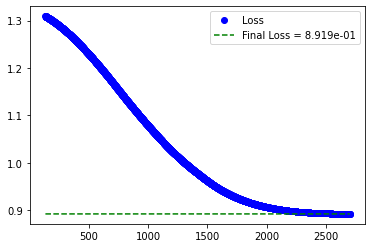

ReHfit: 10.27, Actual: 11.74, Error: 12.54%
ReEfit: -43.57, Actual: -51.74, Error: 15.78%
ReHTfit: 6.60, Actual: 6.52, Error: 1.15%
Chi-Squared Value for this fit: 2.360e-03
Chi-Squared Value for expected fit: 2.379e-03
MSE Loss Value for this fit: 8.919e-01
Average Error for set #11 using ANN = 9.82%
Average Error for set #11 using scipy = 5.96%
-

Avg. Error of ReH = 11.98%
Variance in Error of ReH = 95.17

Avg. Error of ReE = 13.48%
Variance in Error of ReE = 156.11

Avg. Error of ReHT = 7.57%
Variance in Error of ReHT = 22.58


In [8]:
for datset in range(12):
    a = datset*36
    b = a + 36


    xdat = np.asarray([phi[a:b], qq[a:b], xb[a:b], t[a:b], k[a:b], F1[a:b], F2[a:b], const[a:b]])
    x = Variable(torch.from_numpy(xdat[1:5].transpose()))
    y = Variable(torch.from_numpy(ydat[a:b].transpose()))
    xdat = Variable(torch.from_numpy(xdat))
    errs = Variable(torch.from_numpy(errF[a:b]))

    net = torch.nn.Sequential(
        torch.nn.Linear(4, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 100),
        torch.nn.Tanh(),
        torch.nn.Linear(100, 70),
        torch.nn.Sigmoid(),
        torch.nn.Linear(70, 3)
    )
    
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    losses = []
    losses.clear()
    
    for epoch in range(EPOCH):

        p = net(x.float()) #output 3 predicted values for cffs

        ReHfit = torch.mean(torch.transpose(p, 0, 1)[0])
        ReEfit = torch.mean(torch.transpose(p, 0, 1)[1])
        ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2])
        cffs = [ReHfit, ReEfit, ReHTfit]
    
        loss = loss_func(xdat.float(), cffs, errs, y)
        losses.append(float(loss.data.float()))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    plt.plot(np.linspace(int(.05*EPOCH), EPOCH, int(.95*EPOCH)), np.asarray(losses)[int(.05*EPOCH):], 'bo', label='Loss')
    plt.plot(np.linspace(int(.05*EPOCH), EPOCH, int(.95*EPOCH)), np.zeros(int(0.95*EPOCH))+float(loss.data.float()), 'g--',             label='Final Loss = %.3e' % (float(loss.data.float())))
    plt.legend()
    plt.show()

    ReHfit = torch.mean(torch.transpose(p, 0, 1)[0]).data.numpy()
    ReEfit = torch.mean(torch.transpose(p, 0, 1)[1]).data.numpy()
    ReHTfit = torch.mean(torch.transpose(p, 0, 1)[2]).data.numpy()
    fit_cffs = [ReHfit, ReEfit, ReHTfit]

#     plt.plot(phi[a:b], ydat[a:b], 'bo', label='data')
#     plt.plot(phi[a:b], f(xdat,fit_cffs), 'g--', label='fit')
#     plt.legend()
#     plt.show()

    err_H.append(abs(100*(abs(ReHfit-ReH_target[a]))/ReH_target[a]))
    err_E.append(abs(100*(abs(ReEfit-ReE_target[a]))/ReE_target[a]))
    err_HT.append(abs(100*(abs(ReHTfit-ReHT_target[a]))/ReHT_target[a]))
    
    print('ReHfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReHfit, ReH_target[a], abs(100*(abs(ReHfit-ReH_target[a]))/ReH_target[a])))
    print('ReEfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReEfit, ReE_target[a], abs(100*(abs(ReEfit-ReE_target[a]))/ReE_target[a])))
    print('ReHTfit: %.2f, Actual: %.2f, Error: %.2f%%' % (ReHTfit, ReHT_target[a], abs(100*(abs(ReHTfit-ReHT_target[a]))/ReHT_target[a])))

    print('Chi-Squared Value for this fit: %.3e' % (chisquare(f(xdat,fit_cffs), ydat[a:b])[0]))
    print('Chi-Squared Value for expected fit: %.3e' % (chisquare(f(xdat,[ReH_target[a], ReE_target[a], ReHT_target[a]]), ydat[a:b])[0]))
    print('MSE Loss Value for this fit: %.3e' % (float(loss.data.float())))
    print('Average Error for set #%d using ANN = %.2f%%' % ((datset), ((err_H[-1]+err_E[-1]+err_HT[-1])/3)))
    dvcsfit.fit_scipy(datset)
    print('-')

print('\n\033[1m%s%.2f%%' % ('Avg. Error of ReH = ', sum(err_H)/len(err_H)))
print('\033[1m%s%.2f\n' % ('Variance in Error of ReH = ', np.var(err_H)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReE = ', sum(err_E)/len(err_E)))
print('\033[1m%s%.2f\n' % ('Variance in Error of ReE = ', np.var(err_E)))
print('\033[1m%s%.2f%%' % ('Avg. Error of ReHT = ', sum(err_HT)/len(err_HT)))
print('\033[1m%s%.2f' % ('Variance in Error of ReHT = ', np.var(err_HT)))